# Master OWID Dataset (Minimal Version)
In this version we focus on cases/deaths and gogole mobility only and in a way that allows for aggergations across different groupings. To do this we need to limit the raw data to new cases/deaths and we need to convert google mobility data to a per capital measure.

In [19]:
from datetime import date, datetime, timedelta


import pandas as pd
import numpy as np

from loguru import logger
import pycountry

%matplotlib inline

# Params

In [20]:
owid_dataset = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
google_raw_dataset = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'

minimal_owid_covid_dataset = '../data/minimal_owid_covid.pkl'




# The Our World in Data Dataset

## Load the OWID Dataset 

In [21]:
logger.info('Loading OWID dataset @ %s' % owid_dataset)

owid = pd.read_csv(owid_dataset, parse_dates=['date'], low_memory=False)
owid.shape, owid.location.nunique()

2020-09-01 08:38:18.209 | INFO     | __main__:<module>:1 - Loading OWID dataset @ https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv


((40748, 40), 212)

In [22]:
owid = owid.rename(columns={
    'iso_code': 'country_code',
    'location': 'country'
})

owid.date.max()

Timestamp('2020-08-31 00:00:00')

In [23]:
# Drop disputed Kosovo because it causes problems with country codes later
owid = owid[owid['country']!='Kosovo']

# Drop Falklands because they are without a region
owid = owid[owid['country']!='Falkland Islands']

# Drop missing country codes
owid = owid.dropna(subset=['country_code'])

owid.shape, owid.country.nunique()

((40182, 40), 209)

In [24]:
countries_with_some_cases = owid.groupby('country')['total_cases'].max()
countries_with_some_cases = countries_with_some_cases[countries_with_some_cases>0].index

len(countries_with_some_cases)

208

In [25]:
owid = owid[owid['country'].isin(countries_with_some_cases)]

owid.shape, owid['country'].nunique()

((40164, 40), 208)

## Add the 2 letter codes

In [26]:
def lookup_country_code(code, **kwargs):
    country = pycountry.countries.get(**kwargs)
    
    if country: return getattr(country, code)


owid['country_id'] = owid['country_code'].apply(
    lambda country_code: lookup_country_code('alpha_2', alpha_3=country_code)
)

owid = owid[owid['country_id'].notnull()]

owid.shape, owid.country.nunique()

((39919, 41), 207)

## Add Regions

In [27]:
owid['region'] = None

### The Americas

In [28]:
north_america = {
    'northern_america': ['United States', 'Canada', 'Mexico', 'Greenland'],
    
    'central_america': ['Belize', 'Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua', 'Panama'],
    
    'carribean': [
         'Anguilla', 'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Barbados', 'Bermuda', 'British Virgin Islands', 
        'Cayman Islands', 'Cuba', 'Curacao', 'Dominica', 'Dominican Republic', 'Grenada', 'Guadeloupe', 'Haiti', 
        'Jamaica', 'Martinique', 'Montserrat', 'Puerto Rico', 'Saint Kitts and Nevis', 'Saint Lucia', 'Sint Maarten (Dutch part)',
        'Saint Vincent and the Grenadines', 'Trinidad and Tobago', 'United States Virgin Islands', 
        'Bonaire Sint Eustatius and Saba', 'Turks and Caicos Islands']
    
}



for label,countries in north_america.items():
    for country in countries:
        owid['region'] = np.where(owid['country']==country, label, owid['region'])

owid.groupby('region')['country'].nunique(),  owid[owid['region'].isnull()].country.nunique()

(region
 carribean           25
 central_america      7
 northern_america     4
 Name: country, dtype: int64,
 171)

In [29]:
south_america = {
    
    'caribbean_republics ': ['Colombia', 'Venezuela', 'Guyana', 'Suriname', 'French Guiana'],
    
    'andean_republics': ['Bolivia', 'Ecuador', 'Chile', 'Colombia', 'Peru'],
    
    'river_plate_republics': ['Uruguay', 'Paraguay', 'Argentina', 'Brazil'],
}


for label,countries in south_america.items():
    for country in countries:
        owid['region'] = np.where(owid['country']==country, label, owid['region'])

owid.groupby('region')['country'].nunique(),  owid[owid['region'].isnull()].country.nunique()
    

(region
 andean_republics          5
 caribbean_republics       3
 carribean                25
 central_america           7
 northern_america          4
 river_plate_republics     4
 Name: country, dtype: int64,
 159)

### Europe

In [30]:
europe = {
#     'northern_europe': [
#         'Denmark', 'Estonia', 'Faeroe Islands', 'Finland',
#        'Guernsey', 'Iceland', 'Ireland', 'Isle of Man', 'Jersey',
#        'Latvia', 'Lithuania', 'Norway', 'Sweden', 'United Kingdom'
#     ],
    
#     'southern_europe': [
#         'Albania', 'Andorra', 'Bosnia and Herzegovina', 'Croatia',
#        'Gibraltar', 'Greece', 'Italy', 'Macedonia', 'Malta', 'Montenegro',
#        'Portugal', 'San Marino', 'Serbia', 'Slovenia', 'Spain', 'Vatican'
#     ],
    
#     'eastern_europe': [
#         'Belarus', 'Bulgaria', 'Czech Republic', 'Hungary', 'Moldova',
#        'Poland', 'Romania', 'Russia', 'Slovakia', 'Ukraine'
#     ],
    
#     'western_europe': [
#         'Austria', 'Belgium', 'France', 'Germany', 'Liechtenstein',
#        'Luxembourg', 'Monaco', 'Netherlands', 'Switzerland'
#     ],
    
    'non-eu': {
        'Faeroe Islands', 'Guernsey', 'Iceland', 'Isle of Man', 'Jersey', 'Norway', 'United Kingdom',
        'Albania', 'Andorra', 'Bosnia and Herzegovina', 'Gibraltar', 'Macedonia', 'Montenegro',
        'San Marino', 'Serbia', 'Vatican', 'Belarus', 'Moldova',
        'Russia', 'Ukraine', 'Switzerland', 'Liechtenstein',
    },
    
    'eu': {
        'Austria', 'Belgium', 'Bulgaria', 'Croatia','Cyprus', 'Czech Republic', 'Denmark', 
        'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 
        'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
        
    }
    
    
}


for label,countries in europe.items():
    for country in countries:
        owid['region'] = np.where(owid['country']==country, label, owid['region'])
        

owid.groupby('region')['country'].nunique(),  owid[owid['region'].isnull()].country.nunique()

(region
 andean_republics          5
 caribbean_republics       3
 carribean                25
 central_america           7
 eu                       27
 non-eu                   22
 northern_america          4
 river_plate_republics     4
 Name: country, dtype: int64,
 110)

### Africa's Regions

In [31]:
owid['continent'] = np.where(owid['country']=='Egypt', 'Asia', owid['continent'])

In [32]:
africa = {
    'north_africa': [
        'Algeria' ,'Canary Islands' ,'Ceuta' ,'Egypt' ,'Libya' ,
        'Madeira' ,'Melilla' ,'Morocco' ,'Sahrawi Arab Democratic Republic' ,
        'Sudan' ,'Tunisia'
    ],

    'east_africa': [
        'Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'French Southern Territories', 
        'Kenya', 'Madagascar', 'Malawi', 'Mauritius', 'Mayotte', 'Mozambique', 'Reunion', 
        'Rwanda', 'Seychelles', 'Somalia', 'Somaliland', 'South Sudan', 'Tanzania', 'Uganda', 
        'Zambia', 'Zimbabwe', 
    ],

    'central_africa': [
        'Angola', 'Cameroon', 'Central African Republic', 'Chad', 
        'Democratic Republic of Congo', 'Congo', 
        'Equatorial Guinea', 'Gabon', 'Sao Tome and Principe'
    ],

    'west_africa': [
        'Benin', 'Burkina Faso', 'Cape Verde', "Cote d'Ivoire", 'Gambia', 'Ghana', 
        'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 
        'Saint Helena, Ascension and Tristan da Cunha', 'Senegal', 'Sierra Leone', 'Togo',
        'Western Sahara'
    ],

    'southern_africa': [
        'Botswana', 'Swaziland', 'Lesotho', 'Namibia', 'South Africa'
    ],
}

for label,countries in africa.items():
    for country in countries:
        owid['region'] = np.where(owid['country']==country, label, owid['region'])
        
owid.groupby('region')['country'].nunique(),  owid[owid['region'].isnull()].country.nunique()

(region
 andean_republics          5
 caribbean_republics       3
 carribean                25
 central_africa            9
 central_america           7
 east_africa              18
 eu                       27
 non-eu                   22
 north_africa              6
 northern_america          4
 river_plate_republics     4
 southern_africa           5
 west_africa              17
 Name: country, dtype: int64,
 55)

### Asia's Regions

In [33]:
# Adjust Cyprus
owid['continent'] = np.where(owid['country']=='Cyprus', 'Asia', owid['continent'])

In [34]:
asia = {
    'central_asia': ['Tajikistan', 'Uzbekistan', 'Kazakhstan', 'Turkmenistan', 'Kyrgyzstan'],
    
    'east_asia': ['China', 'Mongolia', 'North Korea', 'South Korea', 'Japan', 'Hong Kong', 'Taiwan', 'Macau'],
    
    'south_asia': ['Sri Lanka', 'Bangladesh', 'India', 'Afghanistan', 'Pakistan', 'Bhutan', 'Nepal', 'Maldives'],
    
    'south_east_asia': ['Brunei', 'Cambodia', 'Indonesia', 'Laos', 'Malaysia', 'Myanmar', 'Philippines','Singapore', 'Thailand', 'Timor', 'Vietnam', 'Christmas Island', 'Cocos Islands'],
    
    'western_asia': ['Georgia', 'Armenia', 'Azerbaijan', 'Turkey'],
    
    'middle_east': ['Bahrain', 'Egypt', 'Iran', 'Iraq', 'Israel', 'Jordan', 'Kuwait', 'Lebanon', 'Oman', 'Palestine', 'Qatar', 'Saudi Arabia', 'Syria', 'United Arab Emirates', 'Yemen'],

    
}


for label,countries in asia.items():
    for country in countries:
        owid['region'] = np.where(owid['country']==country, label, owid['region'])
        

owid.groupby('region')['country'].nunique(),  owid[owid['region'].isnull()].country.nunique()

(region
 andean_republics          5
 caribbean_republics       3
 carribean                25
 central_africa            9
 central_america           7
 central_asia              4
 east_africa              18
 east_asia                 5
 eu                       27
 middle_east              15
 non-eu                   22
 north_africa              5
 northern_america          4
 river_plate_republics     4
 south_asia                8
 south_east_asia          11
 southern_africa           5
 west_africa              17
 western_asia              4
 Name: country, dtype: int64,
 9)

In [35]:
# Adjust Georgia to avoid name clash with US state else where.
owid['country'] = np.where(owid['country']=='Georgia', 'Georgia (W. Asia)', owid['country'])

### Oceania's Regions

In [36]:
oceania = {
    'australasia': ['Australia', 'New Zealand'],
    
    'melanesia_micronesia_polynesia': [
        
        # melanesia
        'Fiji', 'New Caledonia', 'Papua New Guinea', 'Solomon Islands', 'Vanuatu',
    
        # micronesia
        'Guam', 'Kiribati', 'Marshall Islands', 'Micronesia (Federated States of)', 
        'Nauru', 'Northern Mariana Islands', 'Palau', 'United States Minor Outlying Islands',
        
        # polynesia
        'American Samoa', 'Cook Islands', 'Easter Island', 'French Polynesia', 
        'Niue', 'Norfolk Island', 'Pitcairn Islands', 'Samoa', 
        'Tokelau', 'Tonga', 'Tuvalu', 'Wallis and Futuna','Rotuma Rotuma'
    ],
    
}


for label,countries in oceania.items():
    for country in countries:
        owid['region'] = np.where(owid['country']==country, label, owid['region'])
        

owid.groupby(['continent', 'region'])['country'].nunique(),  owid.groupby(['continent'])['country'].nunique(), owid[owid['region'].isnull()].country.nunique()

(continent      region                        
 Africa         central_africa                     9
                east_africa                       18
                north_africa                       5
                southern_africa                    5
                west_africa                       17
 Asia           central_asia                       4
                east_asia                          5
                eu                                 1
                middle_east                       15
                south_asia                         8
                south_east_asia                   11
                western_asia                       4
 Europe         eu                                26
                non-eu                            22
 North America  carribean                         25
                central_america                    7
                northern_america                   4
 Oceania        australasia                        2

In [37]:
owid[owid['region'].isnull()].country.unique(), owid.country.nunique()

(array(['Monaco'], dtype=object), 207)

In [38]:
owid = owid.dropna(subset=['country_code', 'country_id'])
owid.shape, owid['country_code'].nunique()

((39919, 42), 207)

## Save as backup 

In [39]:
logger.info('Saving raw OWID dataset @ %s' % '../data/raw_owid_dataset.csv')

owid.to_csv('../data/raw_owid_dataset.csv', index=False)

2020-09-01 08:38:30.976 | INFO     | __main__:<module>:1 - Saving raw OWID dataset @ ../data/raw_owid_dataset.csv


In [40]:
owid.head()

,country_code,continent,country,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,country_id,region
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,AW,carribean
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,AW,carribean
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,AW,carribean
3,ABW,North America,Aruba,2020-03-21,NaN,NaN,0.286,NaN,NaN,0.0,...,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,AW,carribean
4,ABW,North America,Aruba,2020-03-22,NaN,NaN,0.286,NaN,NaN,0.0,...,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,AW,carribean


# The Google Mobility Dataset

In [41]:
logger.info('Loading Google Mobility dataset @ %s' % google_raw_dataset)

google = pd.read_csv(google_raw_dataset, parse_dates=['date'], low_memory=False)

google.shape, google.date.max()

2020-09-01 08:38:32.450 | INFO     | __main__:<module>:1 - Loading Google Mobility dataset @ https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv


((2148055, 14), Timestamp('2020-08-28 00:00:00'))

## Save raw data as backup

In [42]:
logger.info('Saving Google Mobility dataset @ %s' % '../data/raw_google_dataset.csv')

google.to_csv('../data/raw_google_dataset.csv', index=False)
google.shape

2020-09-01 08:38:36.994 | INFO     | __main__:<module>:1 - Saving Google Mobility dataset @ ../data/raw_google_dataset.csv


(2148055, 14)

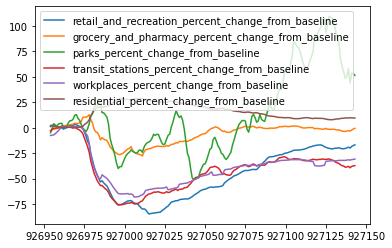

In [43]:
google[(google['country_region_code']=='IE') & (google['sub_region_1'].isnull())].filter(like='from_baseline').rolling(7).mean().plot()

## Country level mobility

In [44]:
# Extract the mobility levels for each top-level country
def gen_for_country(df):
    
    w = 7
    
    # The columns to use for calculating the mobility drop
    use_cols = ['mobility_retail', 'mobility_transit', 'mobility_work']
    
    # Find all the null regions for each country
    countries = df[(df['sub_region_1'].isnull()) & (df['sub_region_2'].isnull()) &(df['metro_area'].isnull())].copy()
    
    # Relabel the cols for convenience
    countries.columns = ['country_id', 'country', 'sub_region_1', 'sub_region_2', 'metro_area', 'iso_3166_2_code', 'census_fips_code', 'date', 'mobility_retail', 'mobility_grocery', 'mobility_parks', 'mobility_transit', 'mobility_work', 'mobility_home']
    
    # Add rolling cols
    for mobility_col in countries.filter(like='mobility_').columns:
        countries['rolling_'+mobility_col] = countries.groupby(
            'country')[mobility_col].apply(
                lambda s: s.rolling(w).mean())
        
    # Calculate the mobility drop
    countries['google_mobility_drop'] = countries[use_cols].mean(axis=1)
    
    return countries[['country_id', 'country', 'date', 'google_mobility_drop']]

google_countries = gen_for_country(google).dropna(subset=['country_id'])

# Convert mobility drop to mobility level
google_countries['google_mobility_level'] = 100+google_countries['google_mobility_drop']

google_countries.shape, google_countries.country.nunique(), google_countries.country.unique()

((26129, 5),
 134,
 array(['United Arab Emirates', 'Afghanistan', 'Antigua and Barbuda',
        'Angola', 'Argentina', 'Austria', 'Australia', 'Aruba',
        'Bosnia and Herzegovina', 'Barbados', 'Bangladesh', 'Belgium',
        'Burkina Faso', 'Bulgaria', 'Bahrain', 'Benin', 'Bolivia',
        'Brazil', 'The Bahamas', 'Botswana', 'Belarus', 'Belize', 'Canada',
        'Switzerland', "Côte d'Ivoire", 'Chile', 'Cameroon', 'Colombia',
        'Costa Rica', 'Cape Verde', 'Czechia', 'Germany', 'Denmark',
        'Dominican Republic', 'Ecuador', 'Estonia', 'Egypt', 'Spain',
        'Finland', 'Fiji', 'France', 'Gabon', 'United Kingdom', 'Georgia',
        'Ghana', 'Greece', 'Guatemala', 'Guinea-Bissau', 'Hong Kong',
        'Honduras', 'Croatia', 'Haiti', 'Hungary', 'Indonesia', 'Ireland',
        'Israel', 'India', 'Iraq', 'Italy', 'Jamaica', 'Jordan', 'Japan',
        'Kenya', 'Kyrgyzstan', 'Cambodia', 'South Korea', 'Kuwait',
        'Kazakhstan', 'Laos', 'Lebanon', 'Liechtenstein', '

# Combine into Minimal Form

In [27]:
owid_cols = ['country', 'country_code', 'continent', 'region', 'new_cases', 'new_deaths', 'population']
google_cols = ['google_mobility_level']

df = owid.set_index(['country_id', 'date'])[owid_cols].join(
    google_countries.set_index(['country_id', 'date'])[google_cols]).reset_index()

df.shape

(38470, 10)

## Drop Negative Counts
It looks like occasionally there are negative cases/deaths in the raw OWID data. Owid seems to drop these dates from its charts so we do the same here.

In [28]:
# df['new_cases'] = df['new_cases'].clip(0)
# df['new_deaths'] = df['new_deaths'].clip(0)

is_neg = (df['new_cases']<0) | (df['new_deaths']<0)

df = df[~is_neg]
df.shape

(38452, 10)

# Aggregations
We can aggregate across continents and regions but need to be careful about how we combine cols by focusing on this columns that can be added across groupings.



## Adjust mobility level so that it is safe to aggregate

In [29]:
# Add a population adjusted mobility level
df['google_mobility_level_by_pop'] = df['google_mobility_level']*df['population']

## Aggregations by Continent and Region

In [30]:
def agg_by(df, groupby_cols, aggregation):
    
    agg_cols = ['new_cases', 'new_deaths', 'population']

    agg = df.groupby(groupby_cols)[agg_cols].sum().reset_index()

    # Aggregate mobility separately to account for population and missing values
    agg_mobility = df[df['google_mobility_level'].notnull()].groupby(
        'date')[['google_mobility_level_by_pop', 'population']].sum().reset_index()

    agg_mobility['google_mobility_level'] = agg_mobility['google_mobility_level_by_pop']/agg_mobility['population']

    # Add to the us aggregation
    agg = agg.set_index('date').join(
        agg_mobility.set_index('date')['google_mobility_level']).reset_index()

    return agg

In [31]:
by_continent = agg_by(df, ['continent', 'date'], 'continent')
by_continent['aggregation'] = by_continent['continent']

by_region = agg_by(df, ['region', 'date'], 'region')
by_region['aggregation'] = by_region['region']

by_world = agg_by(df, 'date', 'world')
by_world['aggregation'] = 'world'

df['aggregation'] = df['country']

df_with_aggs = pd.concat([df, by_continent, by_region, by_world], sort=False, ignore_index=True)
df_with_aggs.shape

(44697, 12)

## Rolling Means

In [32]:
df_with_aggs = df_with_aggs.sort_values(by='date')
df_with_aggs.head()

,country_id,date,country,country_code,continent,region,new_cases,new_deaths,population,google_mobility_level,google_mobility_level_by_pop,aggregation
39883,NaN,2019-12-31,NaN,NaN,NaN,east_asia,27.0,0.0,1.640886e+09,NaN,NaN,east_asia
9938,DO,2019-12-31,Dominican Republic,DOM,North America,carribean,0.0,0.0,1.084790e+07,NaN,NaN,Dominican Republic
17529,IS,2019-12-31,Iceland,ISL,Europe,non-eu,0.0,0.0,3.412500e+05,NaN,NaN,Iceland
38457,NaN,2019-12-31,NaN,NaN,South America,NaN,0.0,0.0,2.302025e+08,NaN,NaN,South America
38456,NaN,2019-12-31,NaN,NaN,Oceania,NaN,0.0,0.0,3.032211e+07,NaN,NaN,Oceania


In [33]:
rolling_cols = ['new_cases', 'new_deaths', 'google_mobility_level']

rolling_means = df_with_aggs.groupby('aggregation').apply(
    lambda g: g[rolling_cols].rolling(7).mean()
).add_suffix('_rolling_mean')

df_with_aggs = pd.concat([df_with_aggs, rolling_means], axis=1)

df_with_aggs.shape

(44697, 15)

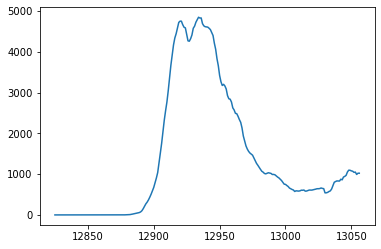

In [34]:
uk = df_with_aggs[df_with_aggs['country']=='United Kingdom']

uk['new_cases_rolling_mean'].plot()

## Relative Values

In [35]:
rel_cols = ['new_cases_rolling_mean', 'new_deaths_rolling_mean', 'google_mobility_level_rolling_mean']

relative_values = df_with_aggs.groupby('aggregation').apply(
    lambda g: g[rel_cols]/g[rel_cols].max()
).add_suffix('_rel')
    
df_with_aggs = pd.concat([df_with_aggs, relative_values], axis=1)

df_with_aggs.shape

(44697, 18)

# Save Dataset

In [36]:
logger.info('Saving minimal OWID dataset with mobility data @ %s' % minimal_owid_covid_dataset)

df_with_aggs.to_pickle(minimal_owid_covid_dataset)
df_with_aggs.shape, minimal_owid_covid_dataset, df_with_aggs.date.max()

2020-08-24 11:36:56.047 | INFO     | __main__:<module>:1 - Saving minimal OWID dataset with mobility data @ ../data/minimal_owid_covid.pkl


((44697, 18),
 '../data/minimal_owid_covid.pkl',
 Timestamp('2020-08-24 00:00:00'))